# ProjectF
1.   Britanya Wright (unity ID : bwright2 )
2.   Arun Gaonkar (unity ID : agaonka )
3.   Sai Harsha Nadendla (unity ID : snadend2 )

The initiation for this problem is at the image
segmentation stage where we have to identify from MRI
images. We will be using a basic Convolutional Neural
Network (CNN) as our baseline model and the proposed
model will be a variant of this.
1. Baseline: A CNN is an algorithm that primarily
rose to prominence because of its ability to take input images, assign weights and biases to different parts of the images and differentiate them
from one another. The data is trained by iterating through the training dataset multiple times and weighing the outputs or applying a bias on the neurons based on how close the output is to the expected output.
2. Proposed: We plan to use variants of CNN called
Fast R-CNN and Mask R-CNN. While a CNN is
adequate to classify the images, to determine the
location of an object, we need to use
segmentation and for that we need Mask R-CNN.
This Mask R-CNN is overlaid on a fast R-CNN
which basically uses the feature maps we get
from the images using normal CNN and then
passes it through a Region Proposal Network
(RPN) which creates boundaries and tries to
determine if an object is there in those
boundaries.

## Checking if CUDA is available

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch

flag_cuda = torch.cuda.is_available()

if not flag_cuda:
    print('Using CPU')
else:
    print('Using GPU')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

Using CPU


## Loading the data

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Do some preprocessing before using the image
# 20% Validation 80% Training
train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
#Getting training data
data_dir = '/content/drive/MyDrive/Final_Project_ECE542/ProjectF/dataset'
train = train_gen.flow_from_directory(data_dir + '/Training',
                               target_size = (150,150),
                               batch_size = 64,
                               class_mode = "categorical",
                               color_mode = "rgb", 
                               shuffle = True,
                               subset = "training"
                                )

classes = train.class_indices

Found 2297 images belonging to 4 classes.


In [ ]:
#Getting validation data
data_dir = '/content/drive/MyDrive/Final_Project_ECE542/ProjectF/dataset'
val = train_gen.flow_from_directory(data_dir + '/Training',
                               target_size = (150,150),
                               batch_size = 64,
                               class_mode = "categorical", 
                               color_mode = "rgb", 
                                shuffle = True,
                                subset = "validation")

Found 573 images belonging to 4 classes.


In [ ]:
#Getting testing data
data_dir = '/content/drive/MyDrive/Final_Project_ECE542/ProjectF/dataset'
test = test_gen.flow_from_directory(data_dir + '/Testing',
                               target_size = (150,150),
                               batch_size = 64,
                               class_mode = "categorical", 
                                shuffle = True,
                                color_mode = "rgb"
                                )

Found 394 images belonging to 4 classes.


# Define the model

In [ ]:
from keras.layers import Conv2D, MaxPool2D, LeakyReLU, BatchNormalization, Dropout, Dense, InputLayer, Flatten
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [ ]:
#model.add(MaxPool2D(pool_size=(6,6)))
model = keras.Sequential()
model.add(InputLayer(input_shape=(150,150,3)))

model.add(Conv2D(filters=64,kernel_size=(3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.6))

model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.5))

model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.5))
model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.5))
model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.5))
model.add(Flatten())
#model.add(Dense(1024, activation='relu'))
#model.add(Dropout(rate=0.3))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(rate=0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.6))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(4, activation='softmax'))
#model.add(Dropout(rate=0.5))


model.compile(optimizer='adam',loss = 'CategoricalCrossentropy',metrics=['accuracy'])

In [ ]:
model.summary(line_length=80)

Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_2 (Conv2D)                  (None, 148, 148, 64)            1792        
                                                                                
 batch_normalization_2 (BatchNormal  (None, 148, 148, 64)           256         
 ization)                                                                       
                                                                                
 max_pooling2d_2 (MaxPooling2D)     (None, 74, 74, 64)              0           
                                                                                
 dropout_6 (Dropout)                (None, 74, 74, 64)              0           
                                                                                
 conv2d_3 (Conv2D)                  (None, 72, 72, 32)              18464       
      

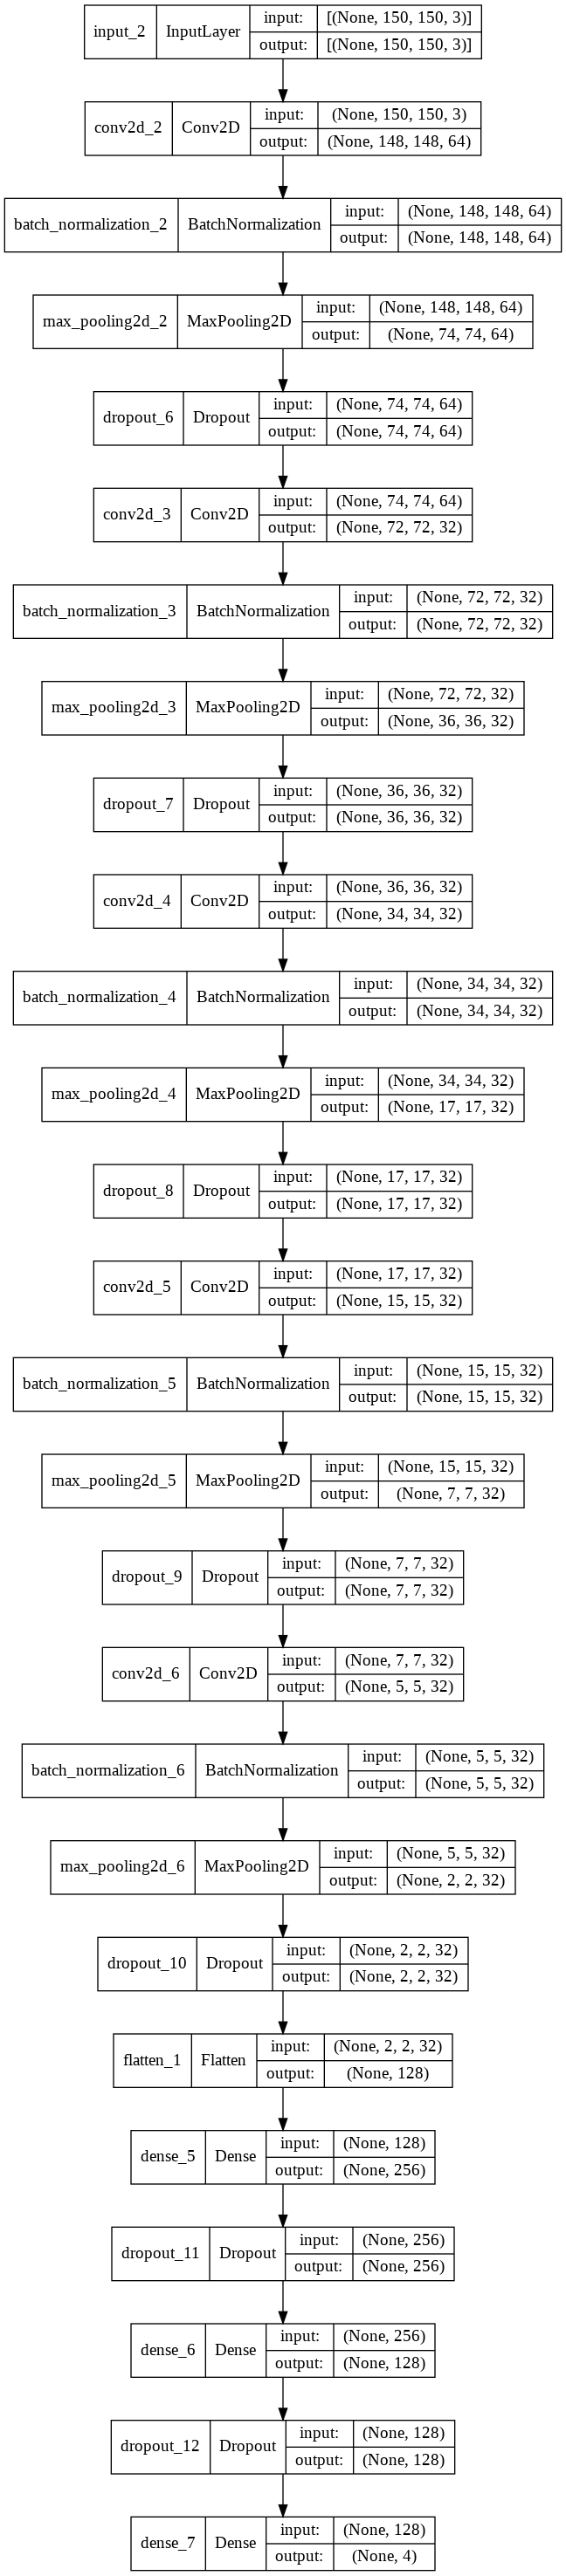

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True,
    show_layer_names=True,
)

# Training the model


In [ ]:
from keras import utils, callbacks

earlystopping = callbacks.EarlyStopping(
    monitor="val_loss", 
    mode="min", 
    patience=5, 
    restore_best_weights = True
    )

In [ ]:
#callbacks = [earlystopping]
history = model.fit_generator(
    train,
    steps_per_epoch = 30,
    verbose=1,
    epochs=3,
    validation_steps = 5, 
    validation_data = (val)
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/3
30/30 [==============================] - 148s 5s/step - loss: 2.0350 - accuracy: 0.2875 - val_loss: 1.4001 - val_accuracy: 0.2719
Epoch 2/3
 4/30 [===>..........................] - ETA: 1:58 - loss: 1.3934 - accuracy: 0.4258

# Evaluating the Model

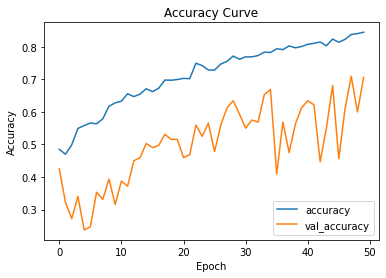

In [ ]:
import matplotlib.pyplot as plt

#Plot the accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')

plt.legend(loc='lower right')

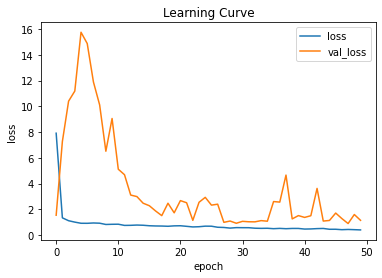

In [ ]:
#Plot the loss  
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Learning Curve')
plt.legend(loc='upper right')

In [ ]:
val_pred = model.predict(val)

In [ ]:
#Evaluation for the Baseline Model 
val_pred = model.predict(val)
p = np.argmax(val_pred,axis=1)
q = np.argmax(val,axis=1)
print("Evaluation for the Baseline Model")
print(classification_report(q,p))

cf_matrix = confusion_matrix(q,p, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot()
plt.show

In [ ]:
classes

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [ ]:
print(val_pred)
print(p)

[[2.5163600e-04 8.9862484e-01 1.5330358e-03 9.9590480e-02]
 [5.0578057e-04 8.8876873e-01 6.3803751e-04 1.1008740e-01]
 [3.0275984e-04 9.2133623e-01 4.7511474e-04 7.7885859e-02]
 ...
 [5.6492863e-04 9.5145029e-01 4.7731568e-04 4.7507454e-02]
 [4.1435458e-04 9.5523900e-01 2.6427588e-04 4.4082355e-02]
 [2.1960275e-04 9.5124149e-01 5.4296816e-04 4.7995843e-02]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [ ]:
q= val.class_indice

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [ ]:
print(len(val))

9
